In [119]:
import quandl
import pandas as pd
import numpy as np
import datetime

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, cross_validation, svm
from sklearn.metrics import accuracy_score,roc_auc_score

%matplotlib inline

In [117]:
def metricas(model,Xt,Xv,yt,yv):
    print "ROC train:%.3f | ROC test:%.3f " %(roc_auc_score(y_true=yt,y_score=model.predict_proba(Xt)[:,1]),roc_auc_score(y_true=yv,y_score=model.predict_proba(Xv)[:,1]))
    print "ACC train:%.3f | ACC test:%.3f " %(accuracy_score(y_true=yt,y_pred=model.predict(Xt)),accuracy_score(y_true=yv,y_pred=model.predict(Xv)))

In [144]:
df = quandl.get("WIKI/GOOGL")

In [184]:
df = df[['Adj. Close']].iloc[-450:]

In [185]:
forecast_out = 30
df['Prediction'] = df[['Adj. Close']].shift(-forecast_out)

In [186]:
df.tail(10)

,Adj. Close,Prediction
Date,,
2018-03-14,1148.89,NaN
2018-03-15,1150.61,NaN
2018-03-16,1134.42,NaN
2018-03-19,1100.07,NaN
2018-03-20,1095.80,NaN
2018-03-21,1094.00,NaN
2018-03-22,1053.15,NaN
2018-03-23,1026.55,NaN
2018-03-26,1054.09,NaN


In [187]:
X = np.array(df.drop(['Prediction'], axis = 1))

In [188]:
X_forecast = X[-forecast_out:] #Ultimos 30
X = X[:-forecast_out] # Excluir los ultimos 30

In [189]:
y = np.array(df['Prediction'])
y = y[:-forecast_out]

In [190]:
Xt, Xv, yt, yv = cross_validation.train_test_split(X, y, test_size = 0.3)
print Xt.shape

(154, 1)


In [191]:
model = MLPRegressor()
model.fit(Xt,yt)
confidence = model.score(Xv, yv)
print("confidence: ", confidence)

('confidence: ', 0.39320938639027925)


In [192]:
X_forecast

array([[ 1054.14],
       [ 1072.7 ],
       [ 1091.36],
       [ 1095.5 ],
       [ 1103.59],
       [ 1113.75],
       [ 1109.9 ],
       [ 1128.09],
       [ 1143.7 ],
       [ 1117.51],
       [ 1103.92],
       [ 1071.41],
       [ 1084.14],
       [ 1094.76],
       [ 1100.9 ],
       [ 1115.04],
       [ 1129.38],
       [ 1160.84],
       [ 1165.93],
       [ 1139.91],
       [ 1148.89],
       [ 1150.61],
       [ 1134.42],
       [ 1100.07],
       [ 1095.8 ],
       [ 1094.  ],
       [ 1053.15],
       [ 1026.55],
       [ 1054.09],
       [ 1006.94]])

In [193]:
forecast_prediction = model.predict(X_forecast)
print(forecast_prediction)

[ 1084.13739129  1103.20770656  1122.38077137  1126.63460247  1134.94704053
  1145.38639415  1141.43053673  1160.12067868  1176.15988242  1149.24977698
  1135.28611403  1101.88223744  1114.96225433  1125.87425584  1132.18307781
  1146.71186326  1161.44614779  1193.77115417  1199.00110593  1172.26567472
  1181.49258372  1183.25987587  1166.62472478  1131.3302566   1126.9428511
  1125.09335931  1083.12017081  1055.78879225  1084.08601652  1035.63960677]


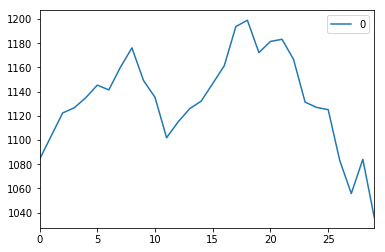

In [194]:
pd.DataFrame(forecast_prediction).plot()

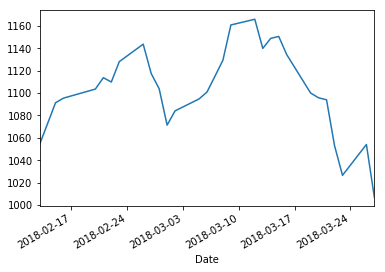

In [195]:
df['Adj. Close'].iloc[-forecast_out:].plot()